In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [4]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [5]:
k_space = range(0.0, 1.0, step = 0.0004)

0.0:0.0004:1.0

In [ ]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)
length(k_space)

In [26]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [27]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: 0.0
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0]
Spectrum: [0.015183804231066184, 0.005298806252304487, -1.0520087403804583e-5, -0.02731980989248711, -6.417618286905454, -11.535348971736727]
Last point: [-0.8216551113414835, -2.684497655285807, 3.8521736396487665, -0.9880460016378185, -4.053009795468564, 3.8187584674034047]
x_sum before truncate length: 4144182
x_sum after truncate length: 2072092
counts: 185
>>>>>>>>>>>>>>>

Initial condition: [-0.8216551113414835, -2.684497655285807, 3.8521736396487665, -0.9880460016378185, -4.053009795468564, 3.8187584674034047]
index: 2
k: 0.0004
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0004]
Spectrum: [0.015035369839707846, 0.005099556770401042, 2.757784664586262e-6, -0.02669491733374705, -6.422081769583061, -11.533125439945778]
Last point: [-0.9691069554167183, -3.762727016061039, 3.9540690072275377, -0.7710624538957785, -2.721335100

Excessive output truncated after 524331 bytes.

counts: 0
>>>>>>>>>>>>>>>



In [28]:
directory = pwd()
filename1 = "\\spectrum_matrix_k1k2_0.17.jld"
filename2 = "\\condition_matrix_k1k2_0.17.jld"
filename3 = "\\EE_array_k1k2_0.17.jld";

In [29]:
save(directory * filename1, "data", spectrum_array)

In [30]:
save(directory * filename2, "data", condition_array)

In [32]:
save(directory * filename3, "data", EVA_array)

In [45]:
directory

"C:\\Users\\olenin.s\\Desktop\\dynamical-systems\\Hindmarrh Rose\\probablity density function"

In [9]:
using CairoMakie

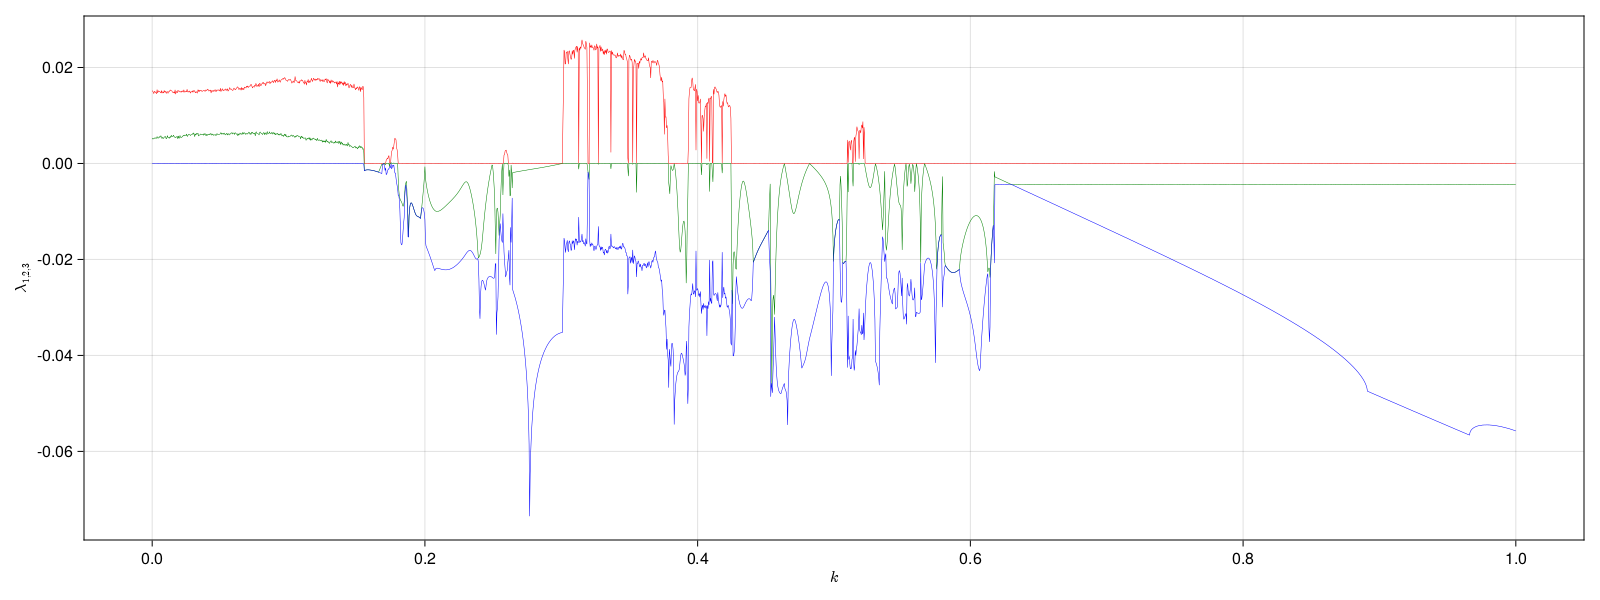

In [53]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f

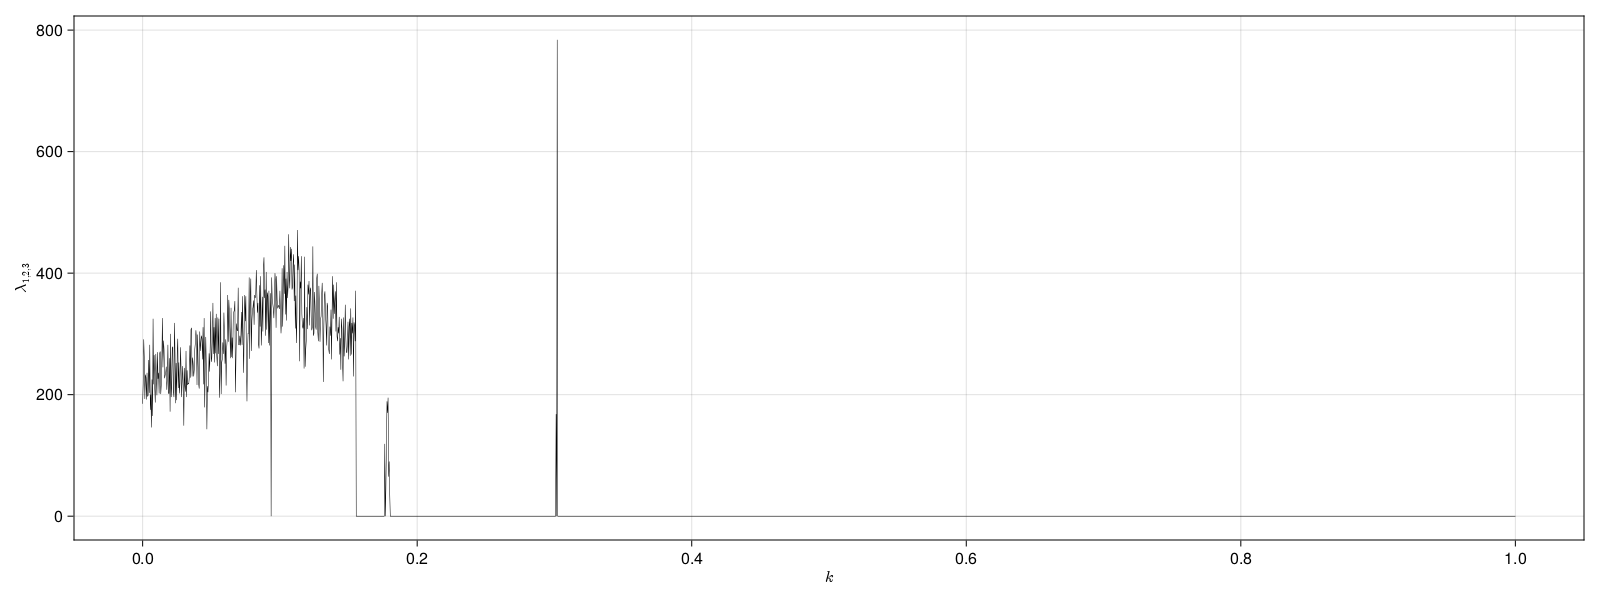

In [10]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, EVA_array, linewidth = 0.5, color = "black")

f

In [55]:
spectrum_array = load("spectrum_matrix_k1k2_0.17.jld")["data"]
condition_array = load("condition_matrix_k1k2_0.17.jld")["data"]
EVA_array = load("EE_array_k1k2_0.17.jld")["data"];

In [64]:
condition_array[:, 756]

6-element Vector{Float64}:
  0.34099576589243524
  0.7425247471496923
  4.200018428218776
 -0.18053232983855308
  0.5061617289909541
  4.194491410447556

In [63]:
k_ = k_space[756]

0.302

In [65]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k_]
u0 = SA[   0.34099576589243524
  0.7425247471496923
  4.200018428218776
 -0.18053232983855308
  0.5061617289909541
  4.194491410447556]
prob = ODEProblem(HR, u0, tspan, p)
sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000);

In [66]:
xsum = sol[1,:] + sol[4,:];
xsum = xsum[floor(Int, length(xsum) / 2):end ];
Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)

2.8494676753643526

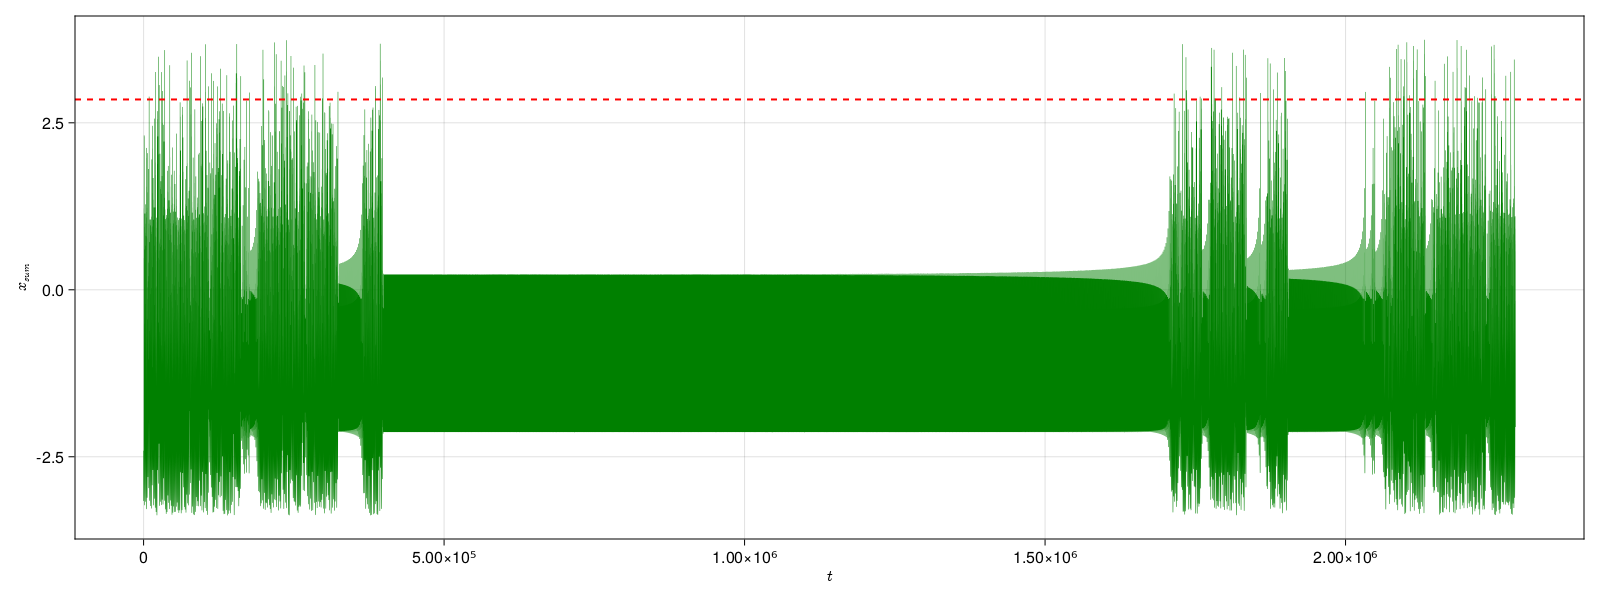

In [67]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"t", ylabel = L"x_{sum}")

lines!(ax, xsum, linewidth = 0.5, color = "green")
hlines!(ax, Hs, linewidth = 2.0, color = "red", linestyle = :dash)
f